# Analyzing Chest X-rays
<span style="color:green;font-weight:700;font-size:24px"> 
Introduction
</span>

Chest x-rays are used to help diagnose a number of medical conditions. Effectively analyzing chest x-rays takes a 
significant amount of training and expertise. Additionaly, there is variability in reader performance over time, 
and between readers. This negatively impacts patient outcomes because it increases the likelihood of misdiagnosis and can 
adversely effect treatment. Computer Aided Diagnostics (CAD) is the use of computers to analyze medical images, and provide 
feedback to the Physician that can help improve diagnostic performance and treatment planning. The goal is only to supplement 
the decision making of humans, not to replace them. The goal of this code repo is to demonstrate some methods for developing CAD tools.
This is intended for educational

Let's start by getting a publicly available data set from kaggle.
https://www.kaggle.com/datasets/nih-chest-xrays/data/data

I picked this data set because it's well studied in the literature, and this version has already converted the DICOM images to .png files. That makes it easy to work with for teaching. By the way DICOM stands for Digital imaging communications in medicine. Its an international standard image format for sharing medical information. You can learn more about it here. https://www.intelerad.com/en/2023/02/23/handling-dicom-medical-imaging-data/


In [2]:
import os # file handling library
import cv2 # image processing library - opencv-python -- cv2 reads BGR so reverse the image channels when plotting with matplotlib
import glob # Unix style path name pattern expansion -- helps to build file lists
import numpy as np # library for matrix math, arrays, etc. 
import pandas as pd # data processing library
import matplotlib.pyplot as plt # plot library

# this helper function lets us plot images so they show up in the .ipython notebook 
def quickplot(img_):
    # make a figure
    plt.figure(figsize = (7,10))
    plt.imshow(img_)
    # get the axes object
    ax = plt.gca()
    # turn off x and y axis
    ax.set_axis_off()
    

<span style="color:green;font-weight:700;font-size:24px"> 
Notes on chest X-Rays 
</span>

Chest X-Rays are formed by passing X-Ray radiation throught the body, and measuring how much of the waves are still present at the detector. Since different tissues and fluids attenuate the waves by different amounts, you'll get contrasting pixels at the detector. Think of X-Ray images as taking a picture of your shadow if your body was transparent by different amounts. If you're old enough to remember those appollo overhead projectors and the plastic sheets, that's a good example too. 

X-ray imaging is a projection imaging modality. The detector is integrating information from a line through your body. So depth information is distorted.

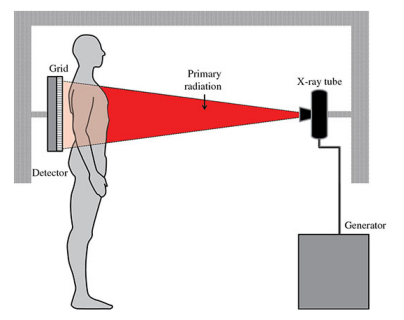

In [3]:
quickplot(cv2.imread('notes_images/figure_0_1_projection_imaging.png')[:,:,::-1])# https://radiologykey.com/projection-x-ray-imaging/

As a fun note, Marie Curie's original X-Ray images were directly measuing the amount of X-ray at the detector. So the tissues and bone show up darker than the rest of the iamge. The background is saturated pixels. So the image looks like the negative of the X-ray images we are familiar with.  


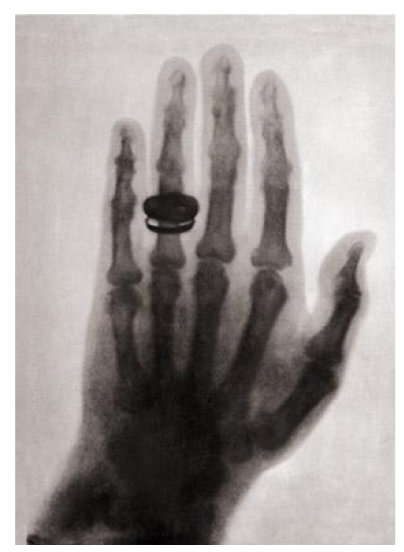

In [4]:
quickplot(cv2.imread('notes_images/Figure 0_0_marie_curie_xreay.png')[:,:,::-1])  # https://danielbirkmd.com/treatments/tests/x-rays

The original method of X-Ray imaging has a high ionizing radiation dose though, and that puts you at much higher risk for developing cancer. I want to make clear that X-Rays are waves with extremely high energy. Their frequency is between about 30 petahertz (10<sup>16</sup> Hz) to 30 exahertz (10<sup>19</sup> Hz).  

To reduce the amount of radiation the patient is exposed to, modern detectors normally take the negative image. That is given by 

$Image(x,y) = Bit Depth - Intensity(x,y)$

Bit depth is the maximum pixel intensity. Some machines use 16-bit images, while RGB images from standard cameras are 8-bit. The better your bit depth the more likely you are to resolve subtle intensity features in the image. The resolution of the image, which is the size of the pixel, will help yousee smaller spatial features in the image. Think edges, curves, small shapes.  

* bit depth https://petapixel.com/2018/09/19/8-12-14-vs-16-bit-depth-what-do-you-really-need/
* more information on contrast, dynamic range, resolutiona and what they mean for X-Ray imaging. https://www.ncbi.nlm.nih.gov/books/NBK564362/
* information on ionizing radiation https://www.cdc.gov/nceh/radiation/ionizing_radiation.html#:~:text=Ionizing%20radiation%20is%20a%20form%20of%20energy%20that%20acts%20by,spectrum%20in%20the%20figure%20below.

<span style="color:green;font-weight:700;font-size:24px"> 
Primer on lung Anatomy and Physiology
</span>

* When you breath, your diaphram is pulling on the bottom of your lungs to lower the pressure inside your lungs and bring air from the outside down you trachea and into the lungs.
* The air goes through your Bronchii, and branches up until it gets to you alveoli. These are responsible for gas exhange and are called the parenchyma.
* The alveoli have pulmonary veins and arteries attached to them to all oxygen to move from the alveoli into your blood stream. Pulmonary arteries are carying deoxygenated blood to the lungs. Pulmonary veins send oxygen rich blood back out to the rest of the body. 
* Gas exchange puts oxygen into your blood, and removes carbon dioxide. Since this works through diffusion, the lungs are made to maximize the surface area of the parenchyma in contact with the blood. 

More detailed information about gas exchange https://opentextbc.ca/biology/chapter/20-2-gas-exchange-across-respiratory-surfaces/#:~:text=(Figure%2020.13).,red%20blood%20cells%20(RBCs).

Below are a couple of diagrams that show some of these parts.   

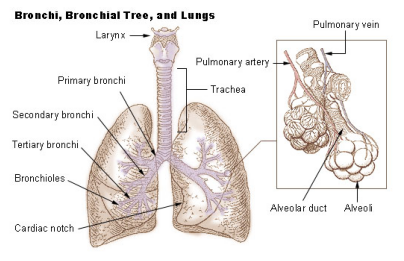

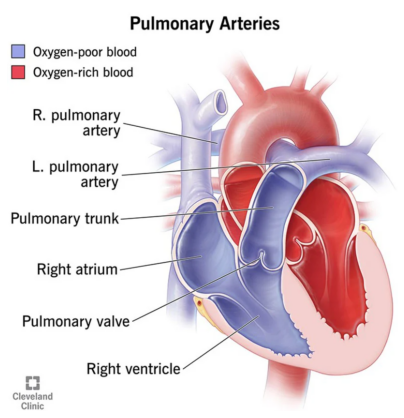

In [5]:
quickplot(cv2.imread('notes_images/figure_0_2_lung_bronchii_alveoli.png')[:,:,::-1]) # https://training.seer.cancer.gov/anatomy/respiratory/passages/bronchi.html
quickplot(cv2.imread('notes_images/figure_0_3_pulmonary_arteries_veins.png')[:,:,::-1]) # https://my.clevelandclinic.org/health/body/21486-pulmonary-arteries

<span style="color:green;font-weight:700;font-size:24px"> 
Lung conditions in this data set
</span>

* Atelectasis: Collapse of a lobe of the lung [1]. 
* Cardiomegaly: Enlarged heat [2]. 
* Consolidation: Fluid / solid  build up in the small air ways. Obscures margins of vessels and airway walls -- this will show up as opacities that look like air ways [3].
* Edema: Build up of fluid in the lungs from pressure imbalance with the heart [4].
* Effusion : fluid build up specifically in the area between the lung and your chest wall [5].
    * this second link has some anatomy diagrams that are helpful [6].
* Emphysema: Shortness of breath caused by damage to the alveoli. The sacs rupture and leave behing much larger spaces in the lung. So this will show up as black lungs in the image from all the space[7]. 
* Fibrosis: Is the thickening and scarring of the tissues in your lungs. So this will result in less blank space in the lung[8].
* Hernia: Bulging of the lung through a soft spot in its surroundings. Usualy this results from trauma, and is rare congenitally (to be born with) [9].
* Infiltration : Fluid / solid  build up in the small air ways. This does not clear up in a short period of time. Later in the data exploration phase, you'll see that infiltration has more follow up visits. [10] 
* Mass : Abnormal growth in the lung that is more than 3 cm - nodules are smaller than that [11]. This is typically associated with cancer.
* No Finding: This denotes that the person doing the imaging study did not see anything worth noting. This does not mean that there is nothing in the image though. 
* Nodule: Abnormal growth in the lung that is smaller than 3 cm. Usually these are associated with cancer.
* Pleural Thickening: Scar tissue expands the lining around the lungs [12]
* Pneumonia: An infection of one or both lunghs that causes parenchyma to fill up with fluid. [13]
* Pneumothorax: Collection of air outside the lung but still inside the chest walls. Lung collapse. [14]

Each of these conditions will have some uniqueness in appearance in the Chest-Xrays compared to the others. There some overlap between appearances due to the simmilarity in the pathology. Note that edema, effusion, infiltration, and pneumonia all involve fluid/solid build up in the air ways of the lungs. So telling these things apart from eachother with the image alone will require very sensitive features and metrics to be captured. 

The aditional meta data may also be useful in separating these classes. The number of follow ups a patient needed shows that the condition persisted over time. Infiltration in particular is a long lasting fluid build up. Notice that hernias are rare congenitally, and usually result from physical trauma and weakness of the surrounding tissues. These conditions are going to be more common in patients engaged in risky physical activity, and in the elderly. Fibrosis is also more likely to occur with age, as our tissues lose elasticity. 

Still meta data not present in this data set could be useful. An example would be blood work, blood pressure, patient weight and height, patient family history, and whether or not the patient also suffers from sleep apnea in the case cardiomegaly. An enlarged heart means large with respect to the size of the patient. The heart will get larger when it has to work harder to push blood around the body. So high blood pressure / hypertension are related to cardiomegaly. In sleep apnea, the patient is suffocating at various points in the night because of air ways blockages or nerve issues, so the heart tries to compensate by trying to wake you up with a faster heart rate. The faster heart rate is also trying to compensate for lower blood oxygenation [15].  

Lastly, a these conditions are not always independant of eachother. The labels co-occur in some examples.

_Note:_ I'm using general links you could find in a google search on these topics. But the more technical information you can get about these conditions, the more details you can incorporate in designing software tools for detecting each condition. 

Links for more information \
[1] https://www.mayoclinic.org/diseases-conditions/atelectasis/symptoms-causes/syc-20369684 \
[2] https://www.mayoclinic.org/diseases-conditions/enlarged-heart/symptoms-causes/syc-20355436 \
[3] https://www.healthline.com/health/lung-consolidation#symptoms \
[4] https://www.yalemedicine.org/conditions/pulmonary-edema#:~:text=Pulmonary%20edema%20describes%20a%20condition,excess%20fluid%20to%20the%20lungs. \
[5] https://bestpractice.bmj.com/topics/en-us/287 \
[6] https://www.ncbi.nlm.nih.gov/books/NBK519048/#:~:text=The%20outer%20layer%20is%20called,vessels%2C%20nerves%2C%20and%20bronchi \
[7] https://www.mayoclinic.org/diseases-conditions/emphysema/symptoms-causes/syc-20355555 \
[8] https://www.lung.org/blog/7-things-know-pulmonary-fibrosis#:~:text=In%20technical%20terms%2C%20fibrosis%20means,scarred%2C%20also%20called%20becoming%20fibrotic \
[9] https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=22&contentid=lunghernia \
[10] https://bestpractice.bmj.com/topics/en-us/1094#:~:text=Persistent%20pulmonary%20infiltrate%20results%20when,1%5D \
[11] https://www.rwjbh.org/treatment-care/cancer/types-of-cancer/lung-thoracic-cancer/lung-mass/#:~:text=A%20lung%20mass%20is%20an,cases%2C%20lung%20masses%20are%20cancerous \
[12] https://www.mesothelioma.com/asbestos-cancer/pleural-thickening/ \
[13] https://www.nhlbi.nih.gov/health/pneumonia#:~:text=Pneumonia%20is%20an%20infection%20that,or%20fungi%20may%20cause%20pneumonia \
[14] https://www.ncbi.nlm.nih.gov/books/NBK441885/#:~:text=A%20pneumothorax%20is%20a%20collection,lung%20and%20make%20it%20collapse \
[15] https://www.sleepresolutions.com/blog/what-does-sleep-apnea-do-to-the-heart#:~:text=Enlarged%20heart%20(cardiomyopathy),the%20bloodstream%20during%20these%20pauses.






<span style="color:green;font-weight:700;font-size:24px"> 
Exploring the meta data 
</span>

Normally we would have to write additional code, or use the pydicom library to convert everything to pngs but here we can jump right in. So first lets get a sense of the data by opening the csv files that come with this data set. We'll use Pandas, which is a library for working with datasets. This way we don't have to write our own code for data reading and writing to the data files. Pandas also has a lot of built in statistical tools. The documentation for this library is at 
https://pandas.pydata.org/docs/index.html

In [6]:
def load_data():
    # this csv has general information about the data
    data = pd.read_csv('../Data_Entry_2017.csv')
    # first lets get the shape of the data 
    print('data shape ', data.shape) # reported as (rows, cols)
    
    # # get column names 
    # print('column names', data.columns)
    return data

# store the data as a global variable -- normally we don't do this. and I try to 
# not do this especially in ipython notebooks, when you want to run things multiple times
# I get it. just hit, clear all outputs restart the kernel and run all. but we should 
# manage out scopes from the begining. 

data_ = load_data()
load_data()  # calling like this will reveal a nice table for the ipython note book


data shape  (112120, 12)
data shape  (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


The column names are explained below. 

* Image Index: filename for the X-Ray
* Finding Labels: This is a description of what was pathological about the image. Some images have no findings
* Patient ID : some images come from the same patient
* Follow-up # : Image from a patient after some number of follow up visits -- notice patient id 1, had cardio megaly, followed by emphysema, then effusion
* Patient Gender : Male, or Female for simplicity
* View Position: Orientation that the X-ray was collected. PA means Posterior - Anterior, it's the prefered orientation because it makes the lungs and heart easier to see. More on this in the X-Ray notes
* OriginalImage[Width Height] : The images in this set were all resized to 1024x1024 pixels, but the original DICOM images were different sizes
* OriginalImagePixelSpacing[x     y] : this is the size of each pixel in x and y, so image resolution

_Note:_ There are now better labels for this data set

* https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest#additional_labels

Next we want to get the distribution of thelabels in the data set. This will let us check for data imbalances and plan accordingly.

Patient Age
{'unique': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 148, 149, 150, 151, 152, 153, 154, 155, 411,
       412, 413, 414], dtype=int64), 'counts': array([  16,   83,   84,  105,  137,  203,  206,  187,  382,  400,  364,
        336,  433,  476,  540,  684,  605,  700,  883,  988, 1190, 1252,
       1296, 1342, 1267, 1248, 1290, 1535, 1390, 1631, 1619, 1688, 1661,
       1791, 1712, 1419, 1444, 1615, 1733, 2020, 1609, 1901, 2067, 2184,
       2397, 2483, 2270, 2332, 2468, 2390, 2556, 2891, 2578, 2

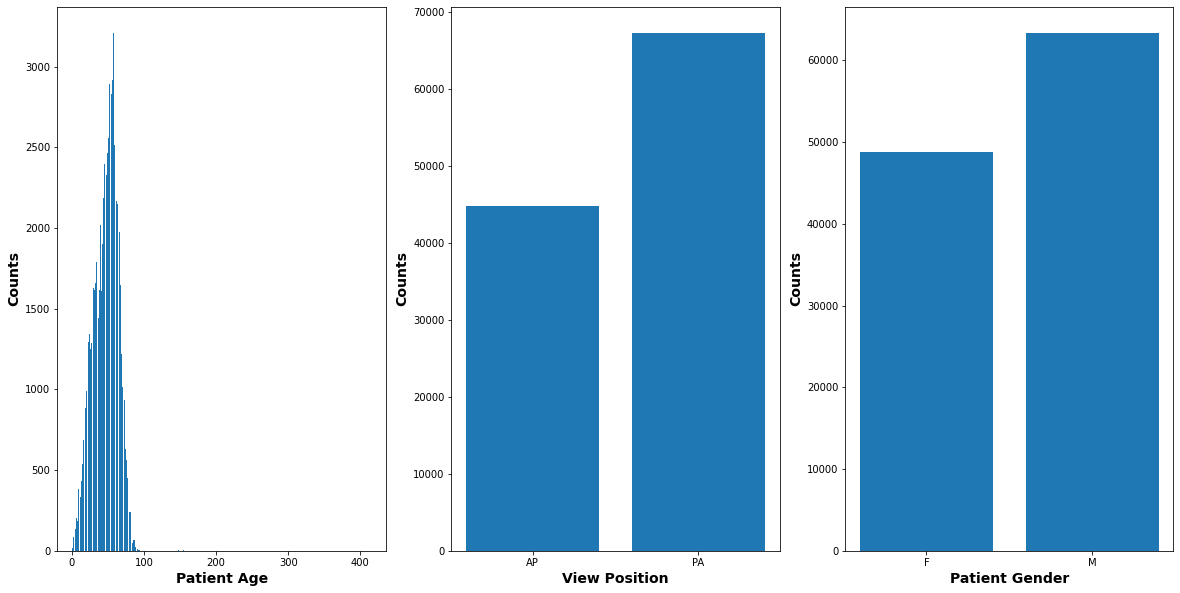

In [7]:
def filter_and_plot(data_):
 
    # I tried making a histogram of this right out of the box
    # Some of the patients are > 400 years old. No way. 
    # World record is Jeanne Calment at 122 so thats the cut off. 
    cols = ['Patient Age', 'View Position', 'Patient Gender']
    # also we will come back to the findings here in a bit - this is better represented in 
    # a coocurence matrix. 
    
    # set up the figure axes
    fig, axes = plt.subplots(1, 3 )
    axes = axes.flatten()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    
    for ci, col in enumerate(cols):
        # It's probably worth it to print off the unique values and get the counts 
        # referencing a data frame like this gives a series
        # series.values returns a numpy array - we can get the unique values with numpy 
        sub_dat = data_[col].values
        
        # get the unique values and their counts
        usub_dat, csub_dat = np.unique(sub_dat, return_counts=True) 
        cc = {'unique': usub_dat, 'counts': csub_dat}
        
        # print out the column names and their unique counts
        print(col)
        print(cc)
        
        # then plot in a nice way

        axes[ci].bar(usub_dat, csub_dat)
        axes[ci].set_xlabel(col, fontsize=14, weight='bold')
        axes[ci].set_ylabel('Counts', fontsize=14, weight='bold')
        # axes[li].set_title(l[0], fontsize = 10, weight='bold')
    plt.show()
    
filter_and_plot(data_)

In [13]:
print('# of samples with age <18', 100*np.sum(data_['Patient Age']<=18)/data_.shape[0])

# of samples with age <18 5.298787013913664


So we can see that Patient Age follows a normal distribution from 1 to 100. Some patients are older than 400. We should filter out any images with age above 122, because  Jeanne Calment holds the world record for age at 122 so thats the cut. Another note about patient age, is that this helps us get a sense for how well the models might translate to pediatric care, adult care, and geriatric care. Models trained on this set may be unreliable for Pediatric data (people under 18) since this only accounts for about 5% of the data. 

If we throw out the AP views we will lose about 40% of the overall labels. The data set also biases male.

We still need to get the distribution of the _Finding Labels_. But recall, physiology allows for multiple findings to occur at the same time. So we need to do some filtration to get the label distribution for individual conditions. Then we can look into co-occurrence.

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']
             condition  counts    percent
7               Hernia     227   0.160382
13           Pneumonia    1431   1.011043
6             Fibrosis    1686   1.191208
3                Edema    2303   1.627136
5            Emphysema    2516   1.777627
1         Cardiomegaly    2776   1.961325
12  Pleural_Thickening    3385   2.391601
2        Consolidation    4667   3.297371
14        Pneumothorax    5302   3.746017
9                 Mass    5782   4.085151
11              Nodule    6331   4.473035
0          Atelectasis   11559   8.166769
4             Effusion   13317   9.408847
8         Infiltration   19894  14.055689
10          No Finding   60361  42.646799
Percent of images with Findings: 57.35320092979221


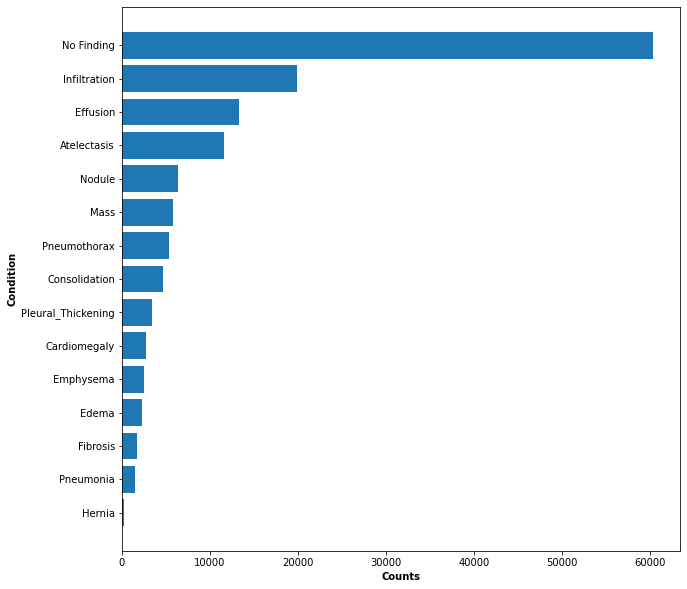

In [ ]:
def label_counter(conditions, data_):
        # so now we can go back and loop through the conditions, to get counts 
        all_count = []
        for cond in conditions:
            # .apply() lets us do some function to an entire column
            # so here I'm using a lambda function to search for the condition
            # in the Finding labels string. 
            mask = data_['Finding Labels'].apply(lambda x:cond in x)
            # you can sum booleans in python. it just treats them as 1s and 0s 
            # so count is the number of times cond in x was true - this fires 1 time per row
            count = np.sum(mask) 
            all_count.append(count)
            
        # make a data frame out of this so we can sort it 
        label_counts = pd.DataFrame.from_dict({'condition':conditions, 'counts': all_count})
        label_counts = label_counts.sort_values('counts')
        label_counts['percent'] = 100*label_counts['counts'] / label_counts['counts'].sum()
        return label_counts

def ocurence(data_):
    # If we print this out, we can see all the conditions are in the first column separated by |
    # and they are alphabetical
    a = np.unique(data_['Finding Labels'].values)
    
    # so then spliting the string up will give all the possible conditions. 
    conditions = data_['Finding Labels'].str.split('|').str[0].values
    conditions = np.unique(conditions)
    print(conditions)

    label_counts = label_counter(conditions, data_)
    print(label_counts)

    sub_labels = label_counts[label_counts['condition'] != 'No Finding']
    print('Percent of images with Findings:', sub_labels['percent'].sum())
    # make a bar plot of the distribution of the labels
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax.barh(label_counts['condition'], label_counts['counts'])
    ax.set_xlabel('Counts', fontsize= 10, weight = 'bold')
    ax.set_ylabel('Condition', fontsize= 10, weight = 'bold')
    
    
    
    plt.show()
    # print(dict(zip(conditions, count)))    
ocurence(data_)

Here, we can see that about 43% of the data has 'No Finding' associated with it, and the other 57% has some finding. The other classes are between 0.1 and 14% of the data. han the exact samples.

Ok enough of that tangent. Let's get back to exploring the data. The next step is to check for which conditions occur together. 

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
15 225


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sums
Atelectasis,0.00,1.25,3.97,0.58,8.59,1.02,0.54,0.11,5.67,0.78,0.00,0.78,0.46,0.37,0.82,24.92
Cardiomegaly,0.00,0.00,0.57,0.37,3.14,0.07,0.08,0.01,0.88,0.07,0.00,0.08,0.06,0.04,0.03,5.41
Consolidation,0.00,0.00,0.00,0.55,4.18,0.26,0.22,0.01,2.60,0.84,0.00,0.55,0.23,0.19,0.24,9.89
Edema,0.00,0.00,0.00,0.00,2.02,0.08,0.02,0.00,2.44,0.13,0.00,0.13,0.07,0.30,0.02,5.20
Effusion,0.01,0.00,0.00,0.00,0.00,1.22,0.62,0.07,13.14,2.98,0.00,1.48,1.39,0.44,1.84,23.18
Emphysema,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.01,1.51,0.56,0.00,0.24,0.30,0.03,1.66,4.44
Fibrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.17,0.29,0.00,0.39,0.37,0.02,0.15,2.41
Hernia,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.07,0.00,0.03,0.02,0.00,0.02,0.26
Infiltration,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.93,0.00,4.58,1.89,1.79,2.47,14.68
Mass,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.04,1.20,0.17,1.14,5.56


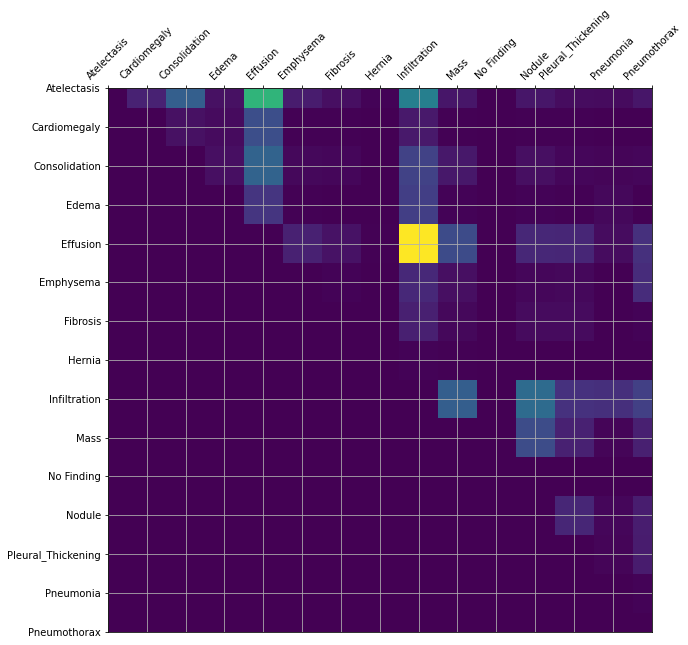

In [ ]:
## For this one, theres a trick. Make a function that takes the condition. Then just replace cond with a longer string. 
## so like, make cond Pneumonia|Fibrosis in x-- pretty sure we can make this reccursive maybe. 

def coocurence(data_):
    # The first part is the same as last time, we want to get the conditions
    conditions = data_['Finding Labels'].str.split('|').str[0].values
    conditions = sorted(np.unique(conditions)) # make sure these are alphabetical
    print(conditions)

    # the next step is to get the pairs of morbidities. 
    coocurs = []
    new_conds = []
    all_count = [] 
    # I want the matrix too, cause it will look nice
    coocur_mat = np.zeros((len(conditions), len(conditions)))
    for ci, cond in enumerate(conditions):
        # we want to get the condition, then pair it up with every other condition
        # We should skip ci < ci2 or something like that to only get
        for ci2, cond2 in enumerate(conditions):
            # if ci2> ci:
            new_cond = cond+'|'+cond2
            mask = data_['Finding Labels'].apply(lambda x:new_cond in x)
            count = np.sum(mask)

            new_conds.append(new_cond)
            all_count.append(count)
            coocurs.append(new_cond)
            coocur_mat[ci, ci2] = 0 + count

    # so now show the coocurence as a table 
    coocur_mat = 100*coocur_mat/np.sum(coocur_mat)
    coocur_data_mat = pd.DataFrame(coocur_mat, columns = conditions, index = conditions)
    
    # make an image of the matrix
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax.imshow(coocur_mat[::-1,...])
    ax.set_xticks(np.arange(0,15), conditions, rotation = 45)
    ax.xaxis.tick_top()
    
    ax.set_yticks(np.arange(0,15)[::-1], conditions)
    ax.grid(xdata=np.arange(0,15)-1, ydata=np.arange(0,15)-1)    
    ax.set_xlim(left = 0, right =14)
    ax.set_ylim(top = 14, bottom =0)
    
    # this should give us the upper right triangle matrix, where the rows are the conditions
    # and the columns are also the conditions. The number of elements is N*(N-1)/ 2 
    # in our case N=15 and the elements should be 105. so print to check 
    print(len(conditions), len(coocurs))  
    # writes out the full table - percent of images with those 2 labels.
    coocur_data_mat['sums'] = coocur_data_mat.sum(axis = 1) 
    coocur_data_mat.loc['Column_Total'] = coocur_data_mat.sum(numeric_only=True, axis=0)
    return coocur_data_mat.style.format(precision = 2) 
coocurence(data_)

The Co-ocurrence matrix shows which conditions occur together and what percent of the data does that combination account for. The rows are the first condition, the columns are the second condition. Notice we have values only in the upper right triangular mtrix. This is because these conditions in the lower triangle matrix are just reverse order of the top one. In this data set,  the labels are listed in alphabetical order though so that helps to clear that lower matrix out. This table and image only show co-occuring pairs, but some cases have more than 2 findings associated. The difference would be to run this again but search for pairs in one input and compare with single labels in the other. There's probably a nice recursive solution for that. But let's keep it simple for now. 

Effusion and infiltration co-occur in 13% of the cases. Effusion also occurs with Atelectasis in 8.5% of the cases. Recall that Effusion is fluid build up between the lung and the chest wall, Actelactesis is a collapse of part of the lung, and infiltration is longterm fluid/solid build up. It's likely that the effusion progressed into infiltration.

From the row sums we can see, Actelactesis appears in combination with another condition in 24% of the data., Effusion appears in 23%, and infiltration happens in combination with 14%. So being able to detect partial lung collapse and fluid build up with a preliminary model may help to improve the performance of a model to detect each of these conditions. Detecting the margins (outlines) of these fluid opacities in the lung can also  be useful when paired with human decision makers.



<span style="color:green;font-weight:700;font-size:24px"> 
Bayes Theorem and and accounting for data imbalance
</span>

Bayes theorem tells us the probability of observing an event A, when we've observed another event B [1]. That is 

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

Prevelance and co-ocurence for each condition can work as the probabilities in the above equation. So that lets us implement a naiive bayes classifier. But the bayes classifier is naiive because it assumes all the variables are independant. As we learned from the physiology this isn't the case in this data set. The real strength in knowing the prevalance and co-occurence is that it allows to balance the our model outputs with some of the following strategies: 

* Weight the training samples' impact on the loss according to their prevalance
* Focal loss is a loss function designed to handle set imbalanaces, and there's other loss functions that can do the same.  
* Upsample the rare classes with generative approahces, hard sample mining, or with augmentation so that the data set becomes balanced. 
* Using an ensemble of binary classifiers --> this requires more training, but lets us set the inputs to take into account special features important to each condition
* Tuining the thresholds on each element of the output vector --> we are going to want to use sigmoid activation if we train to match the labels as presented , each image can have multiple findings.
* Post processing the model predictions following bayes logic to get some amount of confidence for the model output. 

_A note on augmentation:_ The augmentation strategy though, assumes that the user is augmenting the training data and storing the result on a disk. My rationale for doing this is that first, you only need to compute the augmentation functions once, rather than on every loader call. Adding time to the loader call will end up prolonging the training time. Next, augmentation policies are randomly sampling the domain of a particular function. Both sampling techniques should reach a saturation point, where no additional epochs, or no additional samples will give a completly new augmented image. Either way, the paper  'Explaining and harnessing adversarial examples' by Goodfellow et al, suggests that we really care about the direction of model perterbation rather than individual samples.

Then beyond the scope of this section, there are semi supervised learning techniques like contrastive learning (one-shot learning) and masked autoencoders that we can use to pretrain models as well. Transfer learning from models pretrained on large image benchmarks like ImageNet is also useful. 

[1] https://en.wikipedia.org/wiki/Bayes%27_theorem


<span style="color:green;font-weight:700;font-size:24px"> 
How conditions vary with Patient Age, Follow up #, and Patient Gender
</span>

In the previous section we got a measure for how common each condition was, and how often they appear together. The next few plots consider how common the conditions are when grouped by the other patient descriptors in the meta data. This gives some clues about how to incorporate these metrics into the model input. Although, the straight foward approchs is just converting that data into a vector and passing it as a secondary input to our models. 

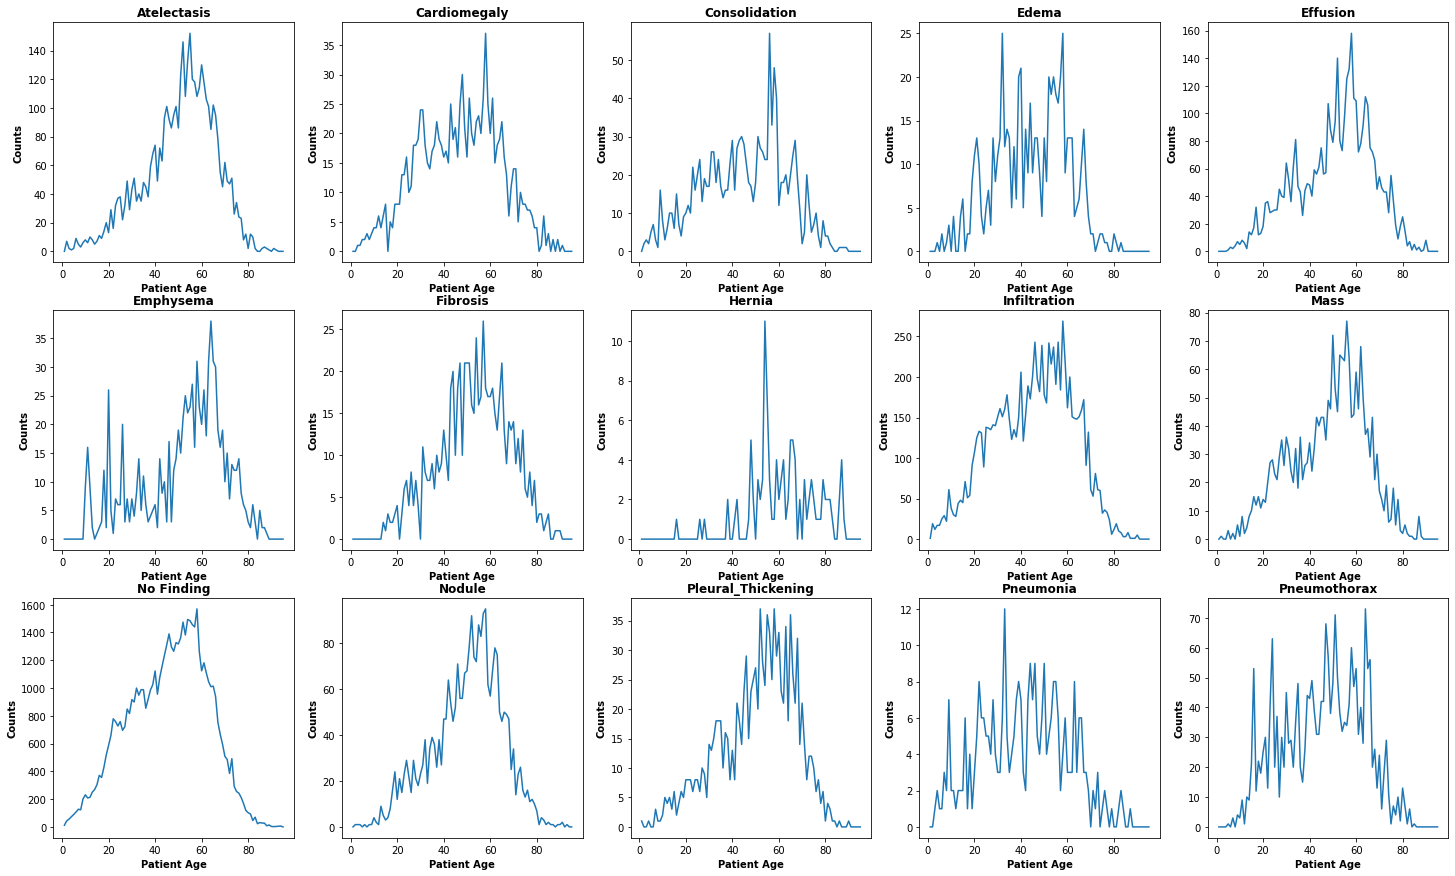

In [ ]:
# we should make this into a function so that we can just apply it into different columns in the main data frame. 
def plot_w_age(data_, metric = 'Patient Age'):
    if metric =='Patient Age':
        data_ = data_[data_['Patient Age']<120]

    # TODO - finding the conditions should really just happen once at the begining of the code
    # and be passed to these functions like we do with data_. 
    conditions = data_['Finding Labels'].str.split('|').str[0].values
    conditions = sorted(np.unique(conditions)) # make sure these are alphabetical
    cond_v_age = {cc:[] for cc in conditions}

    age = np.unique(data_[metric].values)
    
    fig, axes = plt.subplots(3, 5 )
    axes = axes.flatten()
    fig.set_figwidth(25)
    fig.set_figheight(15)

    ii = 0
    for cond in conditions:
        sub_dat = data_[data_['Finding Labels'] == cond]

        for aa in age:
            sub_data = np.sum(sub_dat[metric] == aa)

            cond_v_age[cond].append(sub_data)
        
        
        axes[ii].plot(age, cond_v_age[cond])
        axes[ii].set_xlabel(metric, fontsize=10, weight='bold')
        axes[ii].set_ylabel('Counts', fontsize=10, weight='bold')
        axes[ii].set_title(cond , fontsize = 12, weight='bold')

        if metric == 'Patient Gender':
            axes[ii].set_title(cond+'_ratio_{:.2f}'.format(cond_v_age[cond][0]/cond_v_age[cond][1]),  fontsize = 12, weight='bold')
            # axes[ii].text(5, 5,  )    
            
        ii+=1
    # plt.figure()
    # plt.plot(cond_v_age[conditions[1]])

plot_w_age(data_)     
                

The y-axis on these plots reflects the distribution and co-occurnece data we already recorded. The difference here, is that we can see concentrations in patient conditions in various age groups. Most of the confitions tend to happen between ages 40 and 60 with outliers in younger age groups. The declining tail end is presumably because of life expectancies being met. 

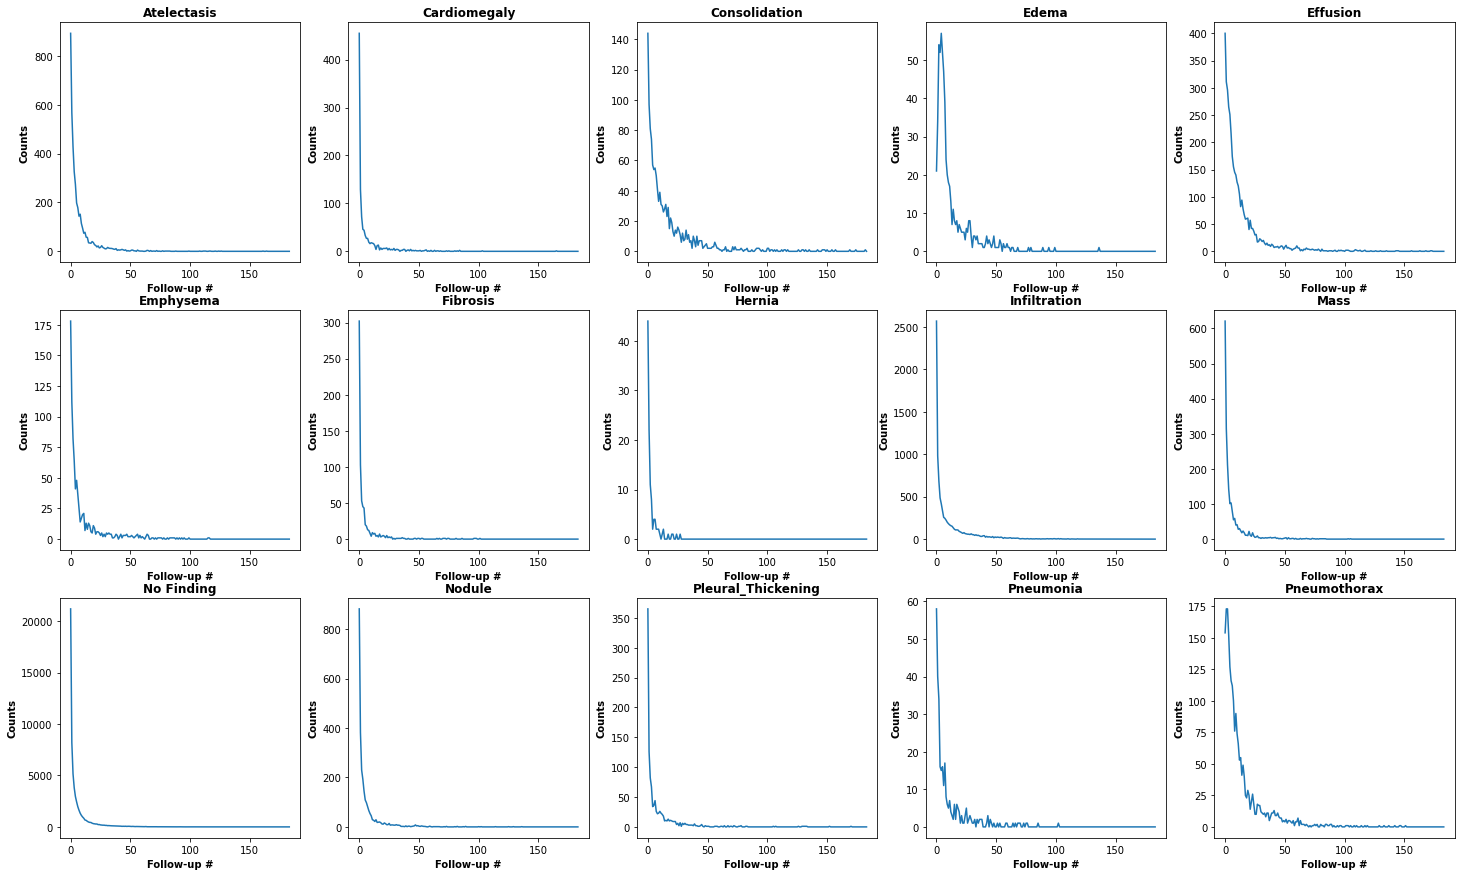

In [ ]:
plot_w_age(data_, metric = 'Follow-up #')

Here, we can see that most of the patients do not have many follow up exams. The actual count for each follow-up # is not as important as the decay of these counts. Most of the patients only have a couple of follow ups. However, conditions like Edema, consolidation, pneumothorax, and pneumonia have more follow-ups. This at least implies that these conditions take some time to progress, but can also mean that these conditions are more threatening and require more monitoring. Since we are going to approach this as a classification task, the Follow-up number may be used as a tie breaker in some conditions.


* The more follow ups the more fatal the ilness

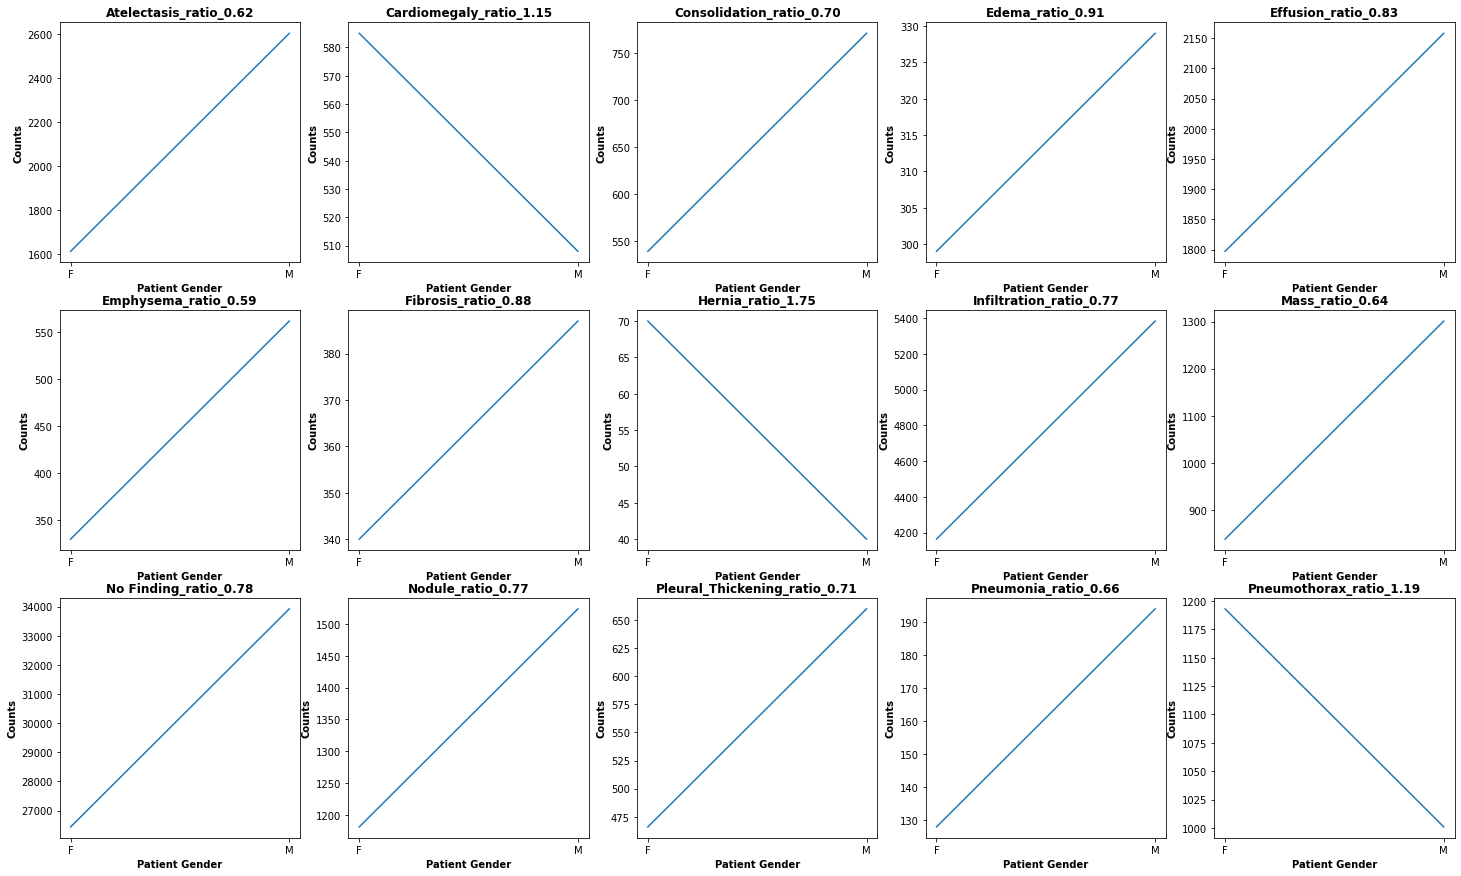

In [ ]:
plot_w_age(data_, metric = 'Patient Gender')

In this data set, there is not a 1 to 1 ratio for Male and Female patients in each condition. The F-to-M ratio is recorded in the title of these plots. We need to be careful here because this does not ncessarily mean that males and females get these conditions at different rates. 

There is probably an argument to be made for being at higher risk of conditions based on differences in lung surface area due to size differences in males and females [1]. But, in that case we should just opt to measure surface areas. Testosterone and estrogen levels also have mechanisms for putting an individual at risk of certain diseases. Here though we probably care more about devations from the average levels. Trends in hormones, weight, and height would probably match up with the above trends, but the deviation from the mean values in male and female cohorts would probably be more useful as a feature than the exact number.

Level of physical activity, body mass index, and muscle mass might also be relavent. 

[1] https://cellandbioscience.biomedcentral.com/articles/10.1186/s13578-023-00998-5#:~:text=However%2C%20sex%20differences%20in%20the,severity%20in%20women%20%5B25%5D.

<span style="color:green;font-weight:700;font-size:24px"> 
Get feedback from pysicians
</span>

So while we have said as much as we can about the data from our plots, it is always a good idea to consult with a physician on the physiology and on what types of features they would like to see when developing these algorithms. 

<span style="color:green;font-weight:700;font-size:24px"> 
Image visualization 
</span>

Next we should look at examples from each class of image. 

(112120,)


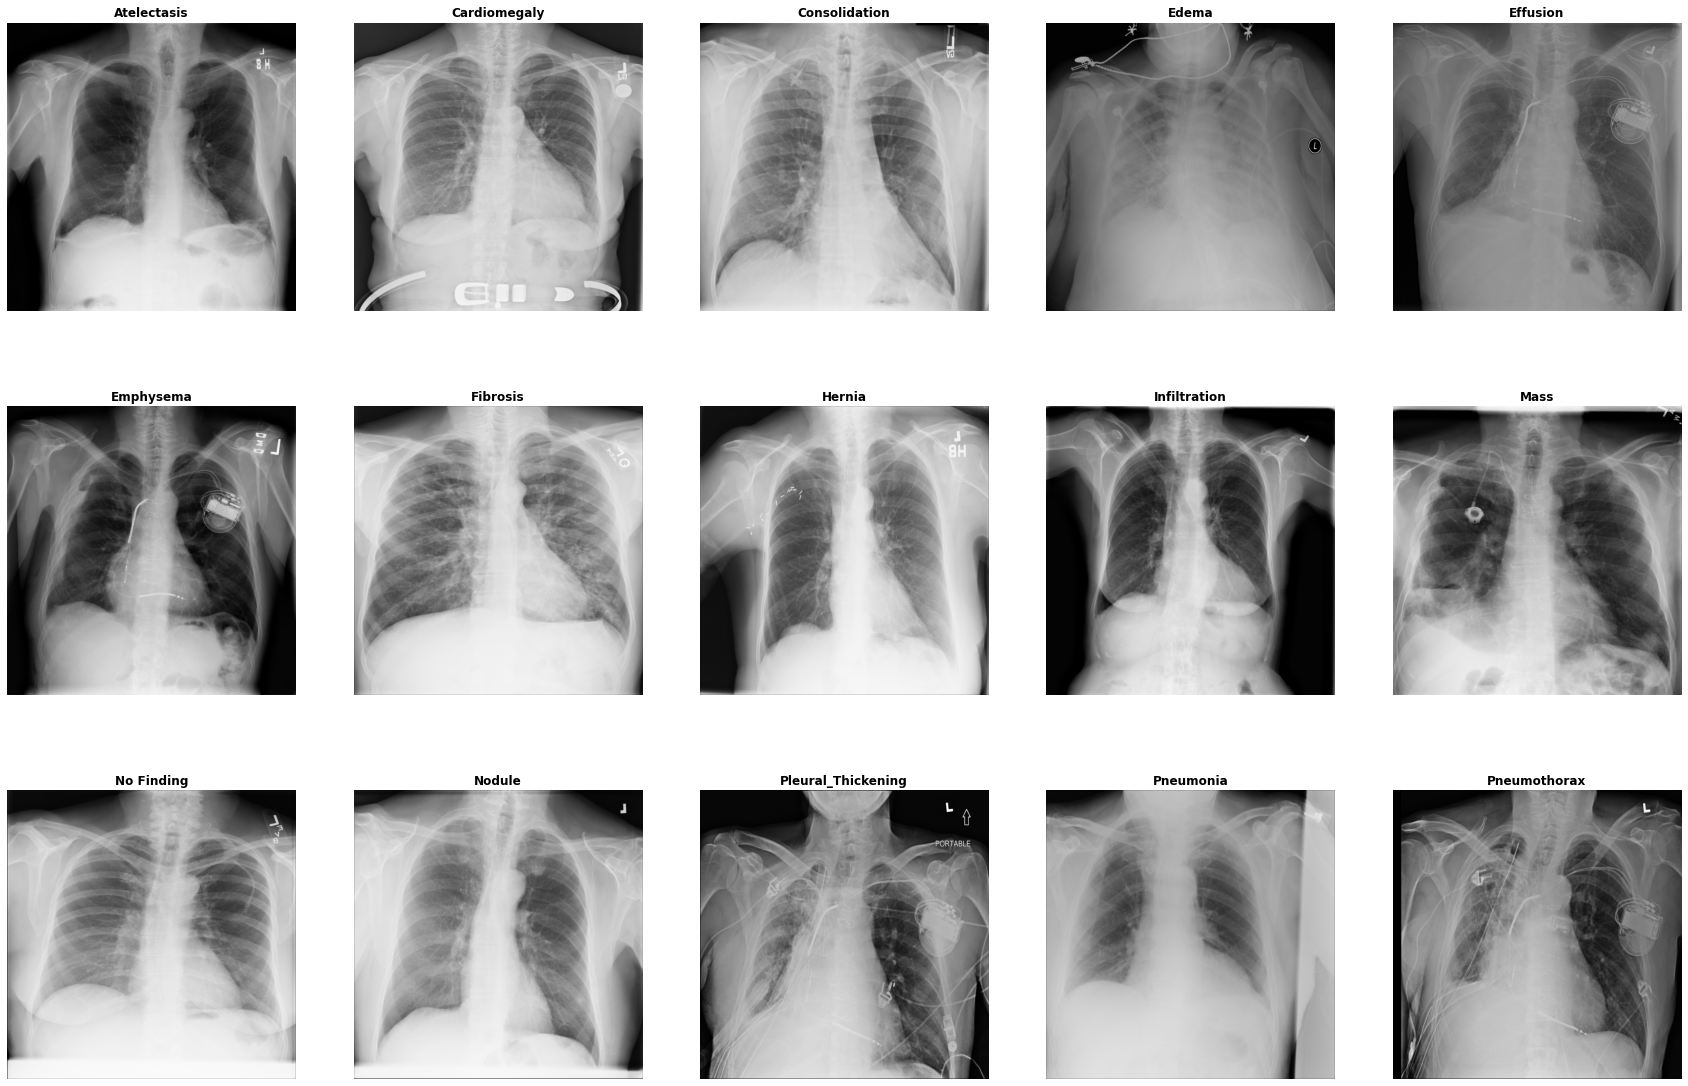

In [ ]:
def disply_conditions(data_):
    conditions = data_['Finding Labels'].str.split('|').str[0].values
    conditions = sorted(np.unique(conditions)) # make sure these are alphabetical
    
    print(data_['Image Index'].shape)
    # paths = sorted(glob.glob(os.path.join('../images_*/images/*.png')))
    data_['full_paths'] = sorted(glob.glob(os.path.join('../images_*/images/*.png')))
    data_.to_csv('../Data_Entry_fullpath_2017.csv') # write this out
    
    fig, axes = plt.subplots(3, 5 )
    axes = axes.flatten()
    fig.set_figwidth(30)
    fig.set_figheight(20)

    for ci, cond in enumerate(conditions):
        sub_data = data_[data_['Finding Labels'] ==cond]
        img_ = cv2.imread(sub_data['full_paths'].iloc[1])[:,:,::-1]

        axes[ci].imshow(img_)
        axes[ci].set_title(cond , fontsize = 12, weight='bold')
        axes[ci].set_axis_off()
disply_conditions(data_)

This type of visualization allows us to get some sense of how each of the condition types presents itself in the chest x-ray. 

<span style="color:green;font-weight:700;font-size:24px"> 
Training plan
</span>

* Train a baseline model that just takes the image as input
* Use model pretrained on imagenet
* Use a model from scratch
* Use a model that that takes image in one branch, and then the text in another brach --> consider Follow up #, patient Age, and gender in one branch, the other branch takes the image -- so like a ViT that also takes text tokens, or a CNN that at in one of the dense layers concatenates a vector for the text. so multimodal input 

_Note:_ The paper, A convnet for the 2020s shoudl have some strategies for improving conv net performance to the range of ViT. So implementing some of those techniques could be beneficial here. 
